In [30]:


def hash_kmer(kmer, num_bins=100000):
    """Hashes a k-mer to one of num_bins using SHA256 and returns an integer index."""
    return int(hashlib.sha256(kmer.encode()).hexdigest(), 16) % num_bins

def load_jellyfish_output(file_path):
    """Loads k-mer counts from a Jellyfish dump file (.tsv)."""
    df = pd.read_csv(file_path, sep=" ", header=None, names=["kmer", "count"], skiprows=1)
    return df

def hash_and_sum_kmers(df, num_bins=100000):
    """Hashes k-mers into num_bins and sums counts using vectorized apply()."""
    # Hash all k-mers to their feature bin
    df["Feature_Index"] = df["kmer"].apply(lambda k: hash_kmer(k, num_bins))

    # Sum counts per bin
    hashed_counts = df.groupby("Feature_Index")["count"].sum()

    # Ensure all bins exist (fill missing ones with 0)
    hashed_df = pd.DataFrame({"Feature_Index": range(num_bins)})
    hashed_df = hashed_df.merge(hashed_counts, on="Feature_Index", how="left").fillna(0)

    hashed_df.set_index("Feature_Index", inplace = True)

    return hashed_df

def get_kmers_main(input_file, bins = 1000):
    #print(f"Loading Jellyfish k-mer counts from {input_file}...")
    df = load_jellyfish_output(input_file)

    #print(f"Hashing {len(df)} k-mers into 100,000 bins and summing counts (vectorized)...")
    hashed_df = hash_and_sum_kmers(df, num_bins=bins)

    # print(f"Saving hashed counts to {output_file}...")
    return(hashed_df)

# df = main("kmers_test.txt")
# df = main("6-kmers_test.txt")
# df.head()

In [22]:
import pandas as pd
import numpy as np
import argparse
import hashlib
import os

      Feature_Index    count
3409           3409  16139.0
501             501  14764.0
1245           1245  14328.0
3847           3847  14084.0
1118           1118  13089.0
Feature_Index    7998000.0
count            5500766.0
dtype: float64
Axes(0.125,0.11;0.775x0.77)


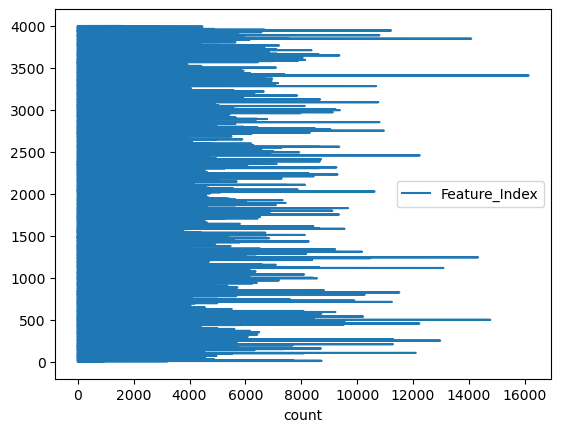

In [32]:
df.shape
print(df.sort_values(by="count", ascending=False).head())

print(df.sum())
# print(df.hist())
print(df.plot("count"))

In [37]:
# merge metadata

stats_df = pd.read_csv("../mgnify_assemblies_stats.csv")
#print(stats_df.head())
#print('---------------')
report_df = pd.read_csv("Study_PRJEB25958/filereport_analysis_PRJEB25958_tsv.txt", sep = "\t")
#print(report_df.head())
#print('---------------')
run_df = pd.read_csv("Study_PRJEB25958/SraRunTable.csv", sep = ",")
#print(run_df.head())
#print('---------------')

# First join: stats_df with report_df on primary_accession = analysis_accession
merged_df1 = stats_df.merge(report_df, left_on="primary_accession", right_on="analysis_accession", how="inner")

# Second join: Merging with run_df on sample_accession = BioSample
merged_df = merged_df1.merge(run_df, left_on="sample_accession", right_on="BioSample", how="inner")

# Display the first few rows of the final merged dataframe
# print(final_df.head())
# print(final_df.shape)

merged_df.loc[:,["Run", "peak_mem_in_gbs"]]

,Run,peak_mem_in_gbs
0,SRR1950750,157
1,SRR1950738,24
2,SRR1950744,50
3,SRR1950767,40
4,SRR1950699,30
...,...,...
89,SRR1950748,71
90,SRR1950715,63
91,SRR1950755,50
92,SRR1950777,48


In [39]:
folder = "Study_PRJEB25958/6mers"

dfs = []
file_names = []

# Iterate over each file in the folder
for sample in os.listdir(folder):
    file_path = os.path.join(folder, sample)
    kmer_hash = get_kmers_main(file_path, bins=600)

    # Extract the filename without extension
    file_name = os.path.splitext(sample)[0]
    file_names.append(file_name)

    # Rename the "counts" column to the filename
    kmer_hash = kmer_hash.rename(columns={"count": file_name})

    #print(kmer_hash)
    dfs.append(kmer_hash)

# Merge all DataFrames side by side using the filenames as column headers
final_df = pd.concat(dfs, axis=1)

# Display the merged DataFrame
print(final_df.head())

               SRR1950706  SRR1950789  SRR1950696  SRR1950721  SRR1950726  \
Feature_Index                                                               
0                     0.0         0.0         0.0         0.0         0.0   
1               3687476.0   2287360.0   2999326.0   3420614.0   4211329.0   
2                     0.0         0.0         0.0         0.0         0.0   
3               3222235.0   1926034.0   3602968.0   3161857.0   4402570.0   
4                     0.0         0.0         0.0         0.0         0.0   

               SRR1950713  SRR1950767  SRR1950765  SRR1950688  SRR1950772  \
Feature_Index                                                               
0                     0.0         0.0         0.0         0.0         0.0   
1               5084032.0   2991001.0   3935316.0   2334702.0   3530640.0   
2                     0.0         0.0         0.0         0.0         0.0   
3               3675220.0   2492709.0   3022948.0    390970.0   3342908.0  

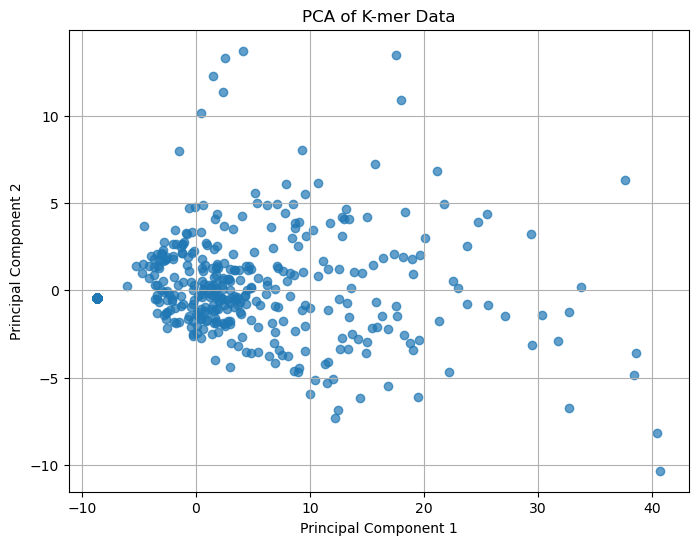

In [35]:
import os
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Ensure final_df is created as per previous steps
# Standardize the data (PCA is sensitive to scale)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_df)

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 principal components for visualization
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"], index=final_df.index)

# Plot the PCA result
plt.figure(figsize=(8, 6))
plt.scatter(pca_df["PC1"], pca_df["PC2"], alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of K-mer Data")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# Assuming final_df contains the features and 'y' is the target variable
X = final_df.drop(columns=['y'])  # Features
y = final_df['y']  # Target variable

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define a simple regression model (Ridge regression)
model = Ridge(alpha=1.0)

# Perform 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='r2')  # R² as metric

# Print cross-validation results
print(f"Cross-validation R² scores: {scores}")
print(f"Mean R² score: {np.mean(scores):.4f}")


In [46]:
# Transpose X to match expected structure
X = final_df.T

# Ensure 'Run' is the index in y
y = merged_df.loc[:, ["Run", "peak_mem_in_gbs"]].set_index("Run")

# Keep only common indices
common_indices = X.index.intersection(y.index)

# Reindex both to have the same order
X = X.loc[common_indices].sort_index()
y = y.loc[common_indices].sort_index()

# Print to check alignment
print(X.head())
print(X.head())
print(X.shape)
print(y.shape)




Feature_Index  0          1    2          3    4          5          6    7    \
SRR1950687     0.0  4936951.0  0.0  4653557.0  0.0  5417333.0  6886188.0  0.0   
SRR1950689     0.0  5440371.0  0.0  4308102.0  0.0  4486270.0  4776860.0  0.0   
SRR1950691     0.0  2958776.0  0.0  2894854.0  0.0  3155133.0  3969156.0  0.0   
SRR1950693     0.0  3073726.0  0.0  3530204.0  0.0  3794575.0  4797041.0  0.0   
SRR1950695     0.0  5753306.0  0.0  6585388.0  0.0  6859244.0  8542609.0  0.0   

Feature_Index  8    9    ...  590        591  592  593        594        595  \
SRR1950687     0.0  0.0  ...  0.0  4325778.0  0.0  0.0  4409578.0  1741732.0   
SRR1950689     0.0  0.0  ...  0.0  4340829.0  0.0  0.0  3632050.0  1744411.0   
SRR1950691     0.0  0.0  ...  0.0  2561392.0  0.0  0.0  1676252.0  1180061.0   
SRR1950693     0.0  0.0  ...  0.0  2729689.0  0.0  0.0  1702780.0  1373866.0   
SRR1950695     0.0  0.0  ...  0.0  4820199.0  0.0  0.0  3062667.0  2535352.0   

Feature_Index        596  597   

Cross-validation R² scores: [0.65050786 0.41002869 0.771172   0.86349711 0.70721443]
Mean R² score: 0.6805


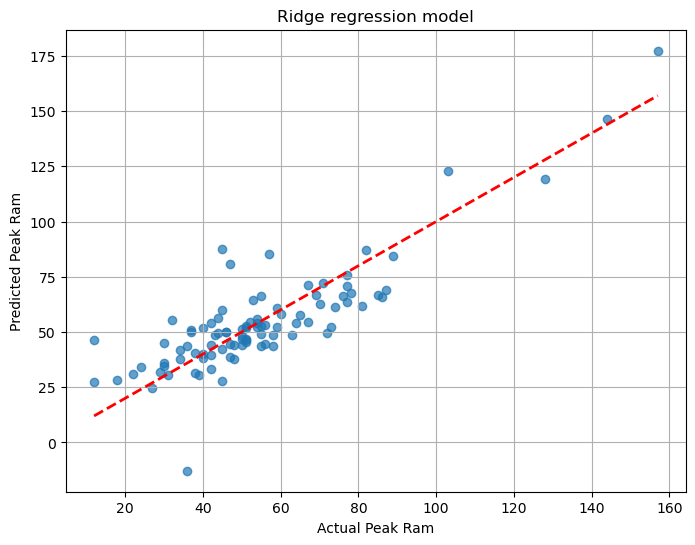

In [62]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Ensure y is a 1D array
# y = y.values.ravel()  # Flatten y to be a 1D array

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define Ridge regression model
model = Ridge(alpha=1.0)

# Set up 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Get cross-validated predictions
y_pred = cross_val_predict(model, X_scaled, y, cv=cv)
scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='r2')  # R² as metric

# Print cross-validation results
print(f"Cross-validation R² scores: {scores}")
print(f"Mean R² score: {np.mean(scores):.4f}")


# Plot actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, alpha=0.7)
# 1:1 line (perfect prediction)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='1:1 line')

# Line that is slightly lower than the 1:1 line (e.g., offset by -0.1)
# plt.plot([y.min(), y.max()], [y.min()-25, y.max()-25], 'b--', lw=2, label='Lower Line')


plt.xlabel("Actual Peak Ram")
plt.ylabel("Predicted Peak Ram")
plt.title("Ridge regression model")
plt.grid(True)
plt.show()

/home/paul/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/paul/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/paul/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/paul/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was

Cross-validation R² scores: [ 0.53600621 -0.06010966  0.63334193  0.49243949  0.3266292 ]
Mean R² score: 0.3857


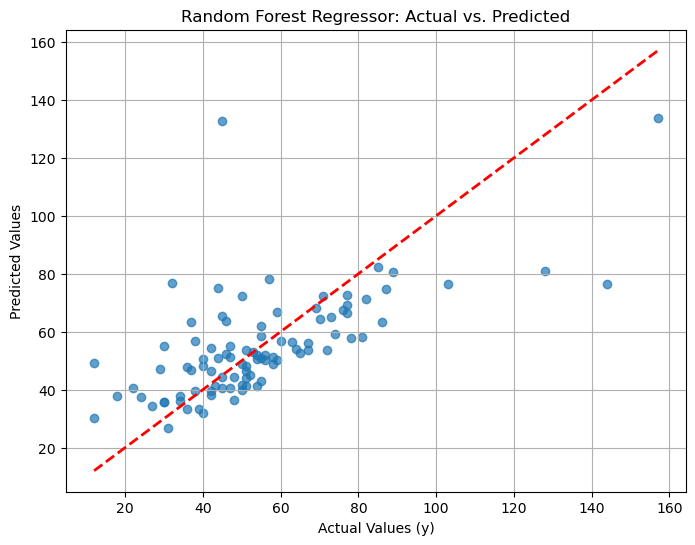

In [51]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Ensure y is a 1D array
y = y.values.ravel()  # Flatten y to be a 1D array

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Set up 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Get cross-validated predictions
y_pred = cross_val_predict(model, X_scaled, y, cv=cv)

scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='r2')  # R² as metric

# Print cross-validation results
print(f"Cross-validation R² scores: {scores}")
print(f"Mean R² score: {np.mean(scores):.4f}")


# Plot actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)  # 1:1 line
plt.xlabel("Actual Values (y)")
plt.ylabel("Predicted Values")
plt.title("Random Forest Regressor: Actual vs. Predicted")
plt.grid(True)
plt.show()